In [2]:
import pandas as pd
# Read in Transcript Data
df_transcripts = pd.read_csv('Data/df_transcripts.csv')

In [3]:
df_transcripts

,transcriptid,mostimportantdateutc,companyid,ticker,full_transcript
0,2718226,2023-01-13,104673.0,UNH,"Good morning, and welcome to the UnitedHealth ..."
1,2718249,2023-01-13,658776.0,JPM,"Good morning, ladies and gentlemen. Welcome to..."
2,2718267,2023-01-13,266311.0,DAL,"Good morning, everyone, and welcome to the Del..."
3,2718283,2023-01-13,19049.0,BAC,"Good day, everyone, and welcome to today's Ban..."
4,2718289,2023-01-13,292891.0,WFC,"Welcome, and thank you for joining the Wells F..."
...,...,...,...,...,...
1172,3605231,2025-11-25,23815047.0,WDAY,Welcome to Workday's Third Quarter Fiscal Year...
1173,3606854,2025-10-29,22967487.0,NOW,"Thank you for standing by. My name is Kate, an..."
1174,3607332,2025-02-13,115705393.0,ABNB,Good afternoon and thank you for joining Airbn...
1175,3607634,2025-04-29,26642.0,KO,"At this time, I'd like to welcome everyone to ..."


In [44]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sentence_transformers import SentenceTransformer
# all-MiniLM-L6-v2 model
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
model = SentenceTransformer("thenlper/gte-large")

import numpy as np

CHUNK_SIZE = 512

all_chunks = []
chunk_index = []

for i, text in enumerate(df_transcripts["full_transcript"]):
    c = chunk(text, size=CHUNK_SIZE)
    all_chunks.extend(c)
    chunk_index.extend([i] * len(c))

chunk_embeddings = model.encode(
    all_chunks,
    batch_size=32,
    show_progress_bar=True
)

# Pool back to docs
dim = chunk_embeddings.shape[1]
doc_embeddings = np.zeros((len(df_transcripts), dim))
counts = np.zeros(len(df_transcripts))

for emb, idx in zip(chunk_embeddings, chunk_index):
    doc_embeddings[idx] += emb
    counts[idx] += 1

doc_embeddings = doc_embeddings / counts[:, None]

df_transcripts["embedding"] = list(doc_embeddings)

Batches:   0%|          | 0/656 [00:00<?, ?it/s]

In [82]:
df_transcripts.to_csv('Data/df_transcripts_embeddings.csv', index = False)

In [45]:
from sklearn.cluster import KMeans
import umap

umap_embeddings = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# Choose k = 10 from elbow plot
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

df_transcripts["cluster"] = labels

df_clusters = df_transcripts[["ticker", "full_transcript", "cluster"]]
df_clusters.head(20)

,ticker,full_transcript,cluster
0,UNH,"Good morning, and welcome to the UnitedHealth ...",7
1,JPM,"Good morning, ladies and gentlemen. Welcome to...",4
2,DAL,"Good morning, everyone, and welcome to the Del...",0
3,BAC,"Good day, everyone, and welcome to today's Ban...",7
4,WFC,"Welcome, and thank you for joining the Wells F...",1
5,C,"Hello, and welcome to Citi's Fourth Quarter 20...",7
6,MS,"Good morning. On behalf of Morgan Stanley, I w...",7
7,GS,"Good morning. My name is Katie, and I will be ...",7
8,UAL,"Good morning, and welcome to United Airlines H...",0
9,PLD,"Greetings, and welcome to the Prologis Fourth ...",5


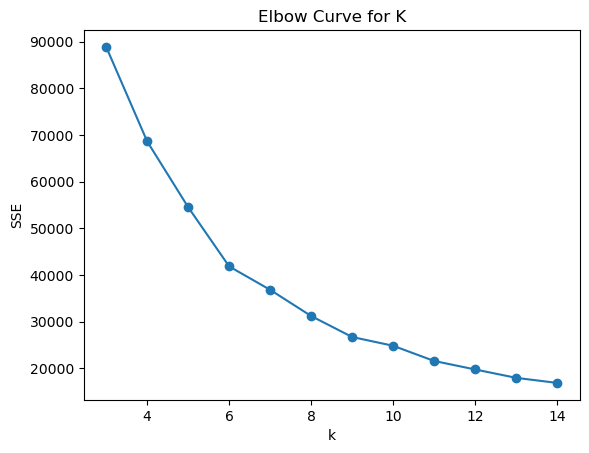

In [40]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

sse = []
K_range = range(3, 15)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10).fit(umap_embeddings)
    sse.append(km.inertia_)

plt.plot(K_range, sse, marker='o')
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Elbow Curve for K")
plt.show()

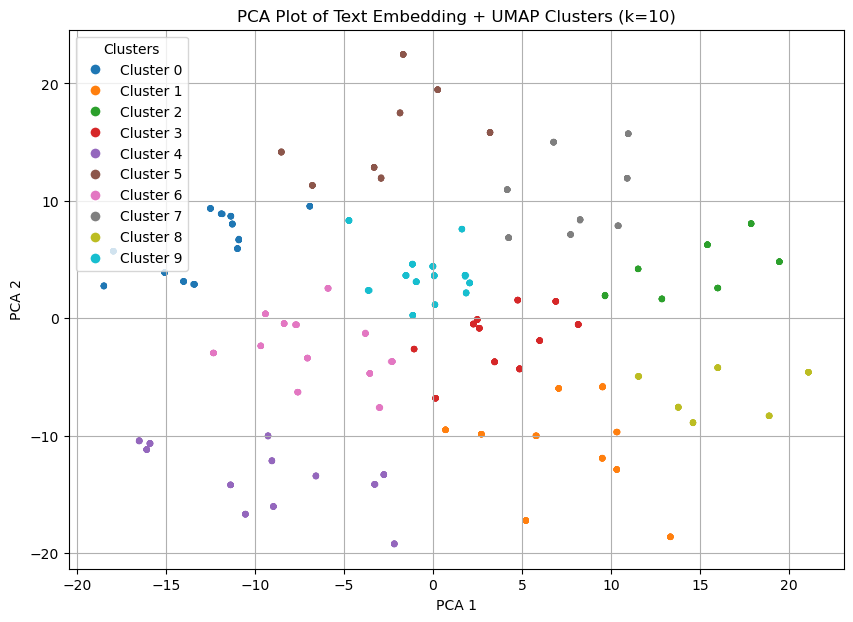

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(umap_embeddings)

plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    pca_emb[:, 0],
    pca_emb[:, 1],
    c=labels,
    cmap="tab10",
    s=12,
    alpha=0.8
)

# Create legend (one entry per cluster)
unique_labels = np.unique(labels)
handles = []
for lbl in unique_labels:
    handles.append(
        plt.Line2D(
            [], [], marker='o', color='w',
            markerfacecolor=plt.cm.tab10(lbl / len(unique_labels)),
            markersize=8, label=f"Cluster {lbl}"
        )
    )

plt.legend(handles=handles, title="Clusters")

plt.title(f"PCA Plot of Text Embedding + UMAP Clusters (k={k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [50]:
df_clusters[df_clusters['cluster'] == 9]['ticker'].value_counts()

ticker
MMM     12
ADP     12
MSFT    12
META    12
TEAM    12
DIS     12
PANW    12
INTU    12
TGT     12
CRM     11
CRWD    11
ORCL    11
RDDT     7
Name: count, dtype: int64

### Apply Analysis on All Transcripts at Company Level

In [59]:
df_grouped = (
    df_transcripts.groupby("ticker")["full_transcript"]
      .apply(lambda x: " ".join(x.astype(str)))
      .reset_index()
)

In [64]:
# Compute embeddings on description
# model = SentenceTransformer("thenlper/gte-large")

umap_embeddings = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# Choose k = 8 from elbow plot
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(umap_embeddings)

df_grouped["cluster"] = labels

df_grouped[["ticker", "full_transcript", "cluster"]].head(20)

,ticker,full_transcript,cluster
0,AA,"Good afternoon, and welcome to the Alcoa Corpo...",2
1,AAPL,"Good day, everyone, and welcome to the Apple Q...",6
2,ABBV,"Good morning, and thank you for standing by. W...",6
3,ABNB,"Good afternoon, and thank you for joining Airb...",0
4,ADBE,"Good day, and welcome to the Q1 FY 2023 Adobe ...",6
5,ADP,"Good morning. My name is Michelle, and I'll be...",3
6,AFRM,Good afternoon. Welcome to Affirm Holdings Sec...,3
7,AMD,"Hello, and welcome to the AMD Fiscal Fourth Qu...",1
8,AMT,"Ladies and gentlemen, thank you for standing b...",4
9,AMZN,"Thank you for standing by. Good day, everyone,...",4


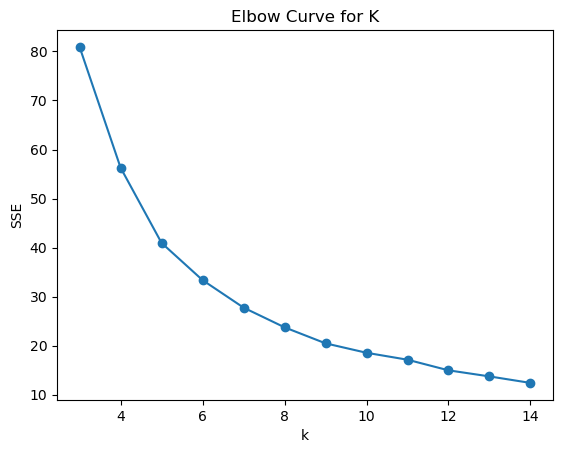

In [65]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

sse = []
K_range = range(3, 15)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10).fit(umap_embeddings)
    sse.append(km.inertia_)

plt.plot(K_range, sse, marker='o')
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Elbow Curve for K")
plt.show()

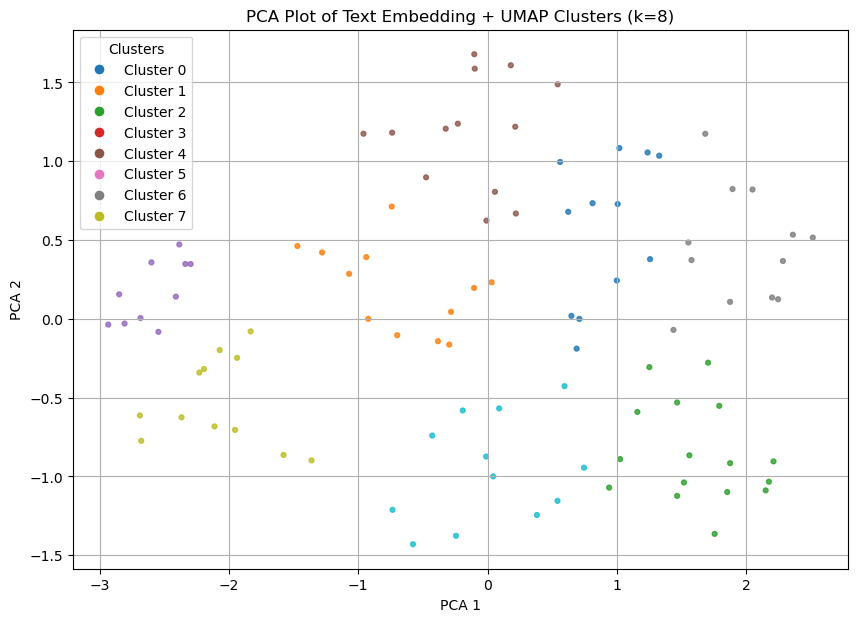

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(umap_embeddings)

plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    pca_emb[:, 0],
    pca_emb[:, 1],
    c=labels,
    cmap="tab10",
    s=12,
    alpha=0.8
)

# Create legend (one entry per cluster)
unique_labels = np.unique(labels)
handles = []
for lbl in unique_labels:
    handles.append(
        plt.Line2D(
            [], [], marker='o', color='w',
            markerfacecolor=plt.cm.tab10(lbl / len(unique_labels)),
            markersize=8, label=f"Cluster {lbl}"
        )
    )

plt.legend(handles=handles, title="Clusters")

plt.title(f"PCA Plot of Text Embedding + UMAP Clusters (k={8})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [79]:
for i in range(7):
    print(f'\n====== Cluster {i} ======')
    print(list(df_grouped[df_grouped['cluster'] == i]['ticker']))


====== Cluster 0 ======
['ABNB', 'DHR', 'JNJ', 'LULU', 'MAR', 'MRK', 'O', 'SPG', 'UBER', 'UNH', 'VZ', 'ZM']

====== Cluster 1 ======
['AMD', 'BAC', 'C', 'CRM', 'EQIX', 'IBM', 'INTC', 'JPM', 'MA', 'MS', 'NVDA', 'TJX']

====== Cluster 2 ======
['AA', 'CAT', 'COP', 'CVX', 'DE', 'DUK', 'EOG', 'HD', 'HON', 'NEE', 'NOW', 'SLB', 'SO', 'TMO', 'WDAY', 'XOM']

====== Cluster 3 ======
['ADP', 'AFRM', 'COST', 'CSCO', 'INTU', 'MSFT', 'ORCL', 'PANW', 'TEAM', 'ZS']

====== Cluster 4 ======
['AMT', 'AMZN', 'CRWD', 'GOOGL', 'GS', 'META', 'NFLX', 'PINS', 'PYPL', 'RDDT', 'SNAP', 'T', 'TMUS']

====== Cluster 5 ======
['BA', 'DAL', 'F', 'GD', 'GE', 'GM', 'LMT', 'NOC', 'RTX', 'TSLA', 'UAL', 'UPS']

====== Cluster 6 ======
['AAPL', 'ABBV', 'ADBE', 'AVGO', 'DIS', 'NKE', 'PFE', 'QCOM', 'SBUX', 'SHOP', 'TGT', 'V']


In [83]:
# Save Clusters to a DataFrame
df_cluster_mapping = df_grouped[['ticker', 'cluster']]
df_cluster_mapping.to_csv('Data/df_cluster_mapping.csv', index = False)